In [20]:
import math
import numpy as np

# Constants
rho0 = 1.225  # Sea level air density (kg/m^3)
h = [0, 5000, 12500, 30]  # Altitudes in meters (takeoff, climb, cruise, landing)
Cd0 = 0.02 # Parasitic drag coefficient 
delta = 0.005  # Induced drag correction factor
AR = 1.5 # Aspect ratio
CL = [1, 0.6, 0.261, 1.5]  # Lift coefficients for phases 
S = 164.9  # Wing area (m^2)
W = 471511.32  # Aircraft weight (N)
gamma = 6  # Climb angle in degrees
v = [68, 80, 290, 56]  # Speeds (m/s) for each phase

# Drag coefficients
Cd = np.array([Cd0 + ((cl ** 2) / (math.pi * AR)) * (1 + delta) for cl in CL])
cd = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, cd in enumerate(cd):
    print(f"{cd} thrust: {Cd[i]:.2f} N")

# Density function
def rho(h):
    rho0 = 1.225
    sea_level_temp = 288.15
    lapse_rate = -0.0065
    R = 287.05
    g = 9.80665
    tropopause_height = 11000

    if isinstance(h, (list, np.ndarray)):
        return np.array([rho(alt) for alt in h])
    if h <= tropopause_height:
        temperature = sea_level_temp + lapse_rate * h
        return rho0 * (temperature / sea_level_temp) ** (-g / (lapse_rate * R))
    else:
        temperature = sea_level_temp + lapse_rate * tropopause_height
        exp_factor = (-g * (h - tropopause_height)) / (R * temperature)
        return rho0 * (temperature / sea_level_temp) ** (-g / (lapse_rate * R)) * math.exp(exp_factor)

# Dynamic pressure calculation
def dynamic_pressure(V, h):
    densities = rho(h)
    return 0.5 * densities * np.array(V)**2

# Thrust required 
def thrust_required(Cd, q, S):
    return Cd * q * S

# Additional thrust for climb
def thrust_required_climb(W, gamma):
    gamma_rad = math.radians(gamma)
    return W * math.sin(gamma_rad)

# thrust calculations for each segements  
q = dynamic_pressure(v, h)  # Dynamic pressure for each segements 
T = [thrust_required(Cd[i], q[i], S) for i in range(len(v))]
T[1] += thrust_required_climb(W, gamma)  # Add climb-specific thrust

#  segment Results
segments = ["Takeoff", "Climb", "Cruise", "Landing"]
print("Dynamic Pressures for each segments:")
for i, segments in enumerate(segments):
    print(f"{segments}: {q[i]:.2f} Pa")

segments = ["Takeoff", "Climb", "Cruise", "Landing"]
for i, segments in enumerate(segments):
    print(f"{segments} thrust: {T[i]:.2f} N")


Takeoff thrust: 0.23 N
Climb thrust: 0.10 N
Cruise thrust: 0.03 N
Landing thrust: 0.50 N
Dynamic Pressures for each segments:
Takeoff: 2832.20 Pa
Climb: 2089.88 Pa
Cruise: 9081.90 Pa
Landing: 1913.98 Pa
Takeoff thrust: 108942.93 N
Climb thrust: 82637.46 N
Cruise thrust: 51709.33 N
Landing thrust: 157760.81 N


In [21]:
theta = 0.752  # Temperature ratio (cruise altitude temp / sea level temp)
M = 0.85       # Mach number
n = 0.8
TSFC0 = 16974.41  # Takeoff thrust

# Correcting the exponentiation operator
TSFC = TSFC0 * (theta ** 0.5) * ((1 + M) ** n)

print(f"Thrust specific fuel consumption: {TSFC:.2f}")
#this still has some problems with it 







Thrust specific fuel consumption: 24079.14


Takeoff: 84610.79 N (total for 2 engines)
Climb: 46072.15 N (total for 2 engines)
Cruise: 21582.91 N (total for 2 engines)
Landing: 5247.97 N (total for 2 engines)


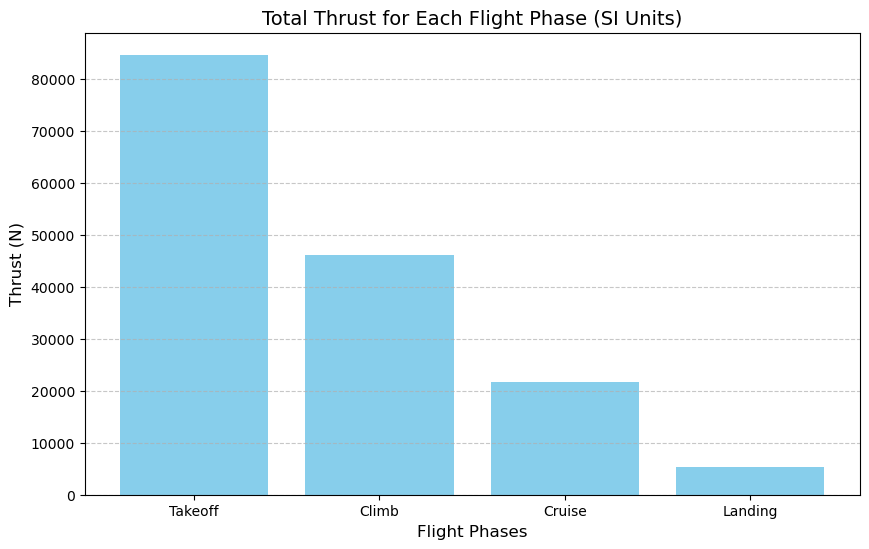

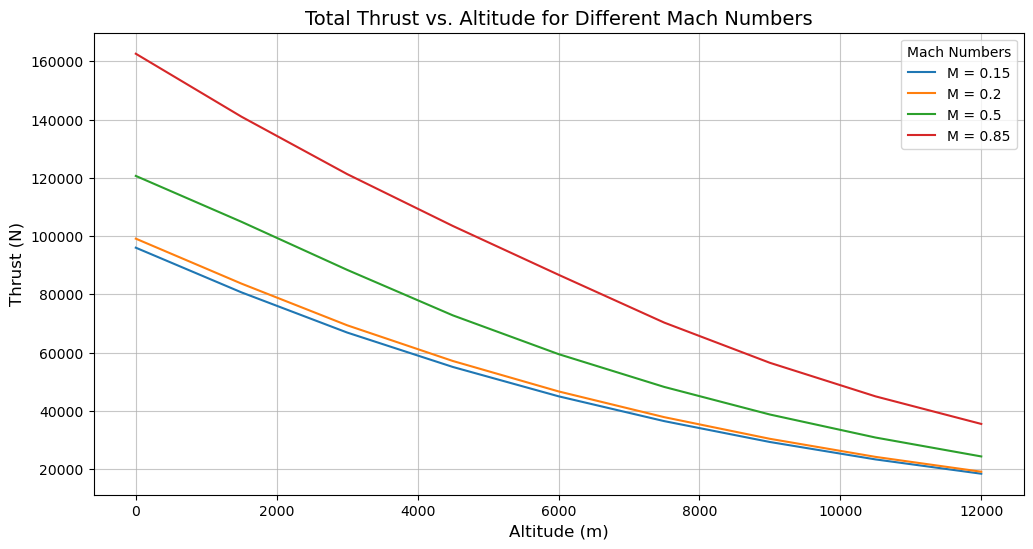

In [22]:
import math
import matplotlib.pyplot as plt

def high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C):
    """
    Calculate thrust for a high bypass ratio turbofan engine based on altitude and Mach number.
    
    Parameters:
        F0 (float): Engine thrust at sea level and ISA, in N.
        TR (float): Throttle ratio.
        H (float): Altitude in meters.
        M (float): Mach number.
        deltaOAT_C (float): Deviation from ISA temperature in °C.
    
    Returns:
        float: Thrust in N.
    """
    # Constants
    T0 = 288.15  # ISA sea level temperature in Kelvin
    P0 = 101325  # ISA sea level pressure in Pa
    R = 287.05  # Specific gas constant for air in J/(kg·K)
    gamma_air = 1.4  # Ratio of specific heats
    a0 = math.sqrt(gamma_air * R * T0)  # Speed of sound at sea level (m/s)
    
    # Atmospheric properties
    if H <= 11000:  # Troposphere
        T = T0 + (-0.0065 * H) + deltaOAT_C  # Temperature at altitude
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R))  # Pressure at altitude
    else:  # Stratosphere (constant temperature)
        T = T0 - 0.0065 * 11000 + deltaOAT_C
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R)) * math.exp(
            -9.80665 * (H - 11000) / (R * T)
        )
    
    rho = P / (R * T)  # Air density in kg/m³
    sigma = rho / 1.225  # Density ratio
    
    # Pressure ratio
    delta = P / P0 * (1 + 0.2 * M ** 2) ** 3.5
    
    # Temperature ratio
    theta = T / T0 * (1 + 0.2 * M ** 2)
    
    # High Bypass Ratio Turbofan Calculation
    if theta <= TR:
        thrust = F0 * delta * (1 + 0.49 * math.sqrt(M))
    else:
        thrust = F0 * delta * (1 + 0.49 * math.sqrt(M) - 3 * (theta - TR) / (1.5 + M))
    
    return thrust

# Flight phase-specific parameters in SI units
flight_phases = {
    "Takeoff": {"H": 0, "M": 0.2, "TR": 0.9, "deltaOAT_C": 0}, #TR 0.9-1 because full power is required at takeoff
    "Climb": {"H": 5000, "M": 0.3, "TR": 0.8, "deltaOAT_C": -5}, # TR 0.75-0.85 because moderate power is required at climb
    "Cruise": {"H": 12500, "M": 0.9, "TR": 0.6, "deltaOAT_C": -10},#TR 0.5-0.7 because low power is required at cruise 
    "Landing": {"H": 0, "M": 0.15, "TR": 0.4, "deltaOAT_C": 5}, # TR 0.3-0.5 because very low  power is required to decent 
}

# Constants
F0 = 40000  # Sea level thrust per engine in N
num_engines = 2  # Number of engines

# Calculate thrust for each phase
thrust_results = []
phases = []
for phase, params in flight_phases.items():
    H = params["H"]
    M = params["M"]
    TR = params["TR"]
    deltaOAT_C = params["deltaOAT_C"]
    
    thrust = high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C)
    total_thrust = thrust * num_engines  # Total thrust for two engines
    thrust_results.append(total_thrust)
    phases.append(phase)
    print(f"{phase}: {total_thrust:.2f} N (total for {num_engines} engines)")

# Visualization: Bar plot for thrust in each phase
plt.figure(figsize=(10, 6))
plt.bar(phases, thrust_results, color='skyblue')
plt.title("Total Thrust for Each Flight Phase (SI Units)", fontsize=14)
plt.ylabel("Thrust (N)", fontsize=12)
plt.xlabel("Flight Phases", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization: Thrust vs. Altitude and Mach Number
altitudes = range(0, 12500, 1500)  # Altitudes from 0 to 11,000 m
mach_numbers = [0.15, 0.2, 0.5, 0.85]  # Example Mach numbers (Landing, Takeoff, Climb, Cruise)

plt.figure(figsize=(12, 6))
for M in mach_numbers:
    thrusts = [
        high_bypass_turbofan_thrust(F0, 1.0, H, M, 0) * num_engines for H in altitudes
    ]
    plt.plot(altitudes, thrusts, label=f"M = {M}")

plt.title("Total Thrust vs. Altitude for Different Mach Numbers", fontsize=14)
plt.ylabel("Thrust (N)", fontsize=12)
plt.xlabel("Altitude (m)", fontsize=12)
plt.legend(title="Mach Numbers", fontsize=10)
plt.grid(alpha=0.7)
plt.show()
